<b>This notebook was written with the aim of classifying the RNA strands of a number of patients, based on provided features observed.<b>

In [1]:
import json
import os
import gc

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_svmlight_files
import joblib

from jupyterthemes import jtplot
jtplot.style('gruvboxd')

%matplotlib
%matplotlib inline

Using matplotlib backend: <object object at 0x0000014337FD1260>


In [2]:
### Random seed generator
np.random.default_rng(2021)

Generator(PCG64) at 0x1433CB80AC0

In [3]:
### Import sparse datasets
DIR = os.getcwd().replace('notebooks', '')
X_train, y_train, X_test, y_test = load_svmlight_files([os.path.join(DIR, 'data', 'dataset', f)
                                                        for f in ['cod-rna.t', 'cod-rna.txt']])

In [4]:
### Convert sparse datasets to dense format
X_train = pd.DataFrame(X_train.todense())
X_test = pd.DataFrame(X_test.todense())

In [5]:
### Peak at the first few rows of our train dataset
X_train.head()

,0,1,2,3,4,5,6,7
0,-500.0,128.0,0.140625,0.304688,0.234375,0.129771,0.328244,0.229008
1,-541.0,123.0,0.140625,0.304688,0.234375,0.146341,0.333333,0.211382
2,-479.0,124.0,0.140625,0.304688,0.234375,0.137097,0.322581,0.233871
3,-427.0,128.0,0.140625,0.304688,0.234375,0.153846,0.392308,0.184615
4,-478.0,120.0,0.140625,0.304688,0.234375,0.250000,0.216667,0.275000


In [6]:
X_train.shape

(271617, 8)

In [7]:
X_test.shape

(59535, 8)

In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271617 entries, 0 to 271616
Data columns (total 8 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       271617 non-null  float64
 1   1       271617 non-null  float64
 2   2       271617 non-null  float64
 3   3       271617 non-null  float64
 4   4       271617 non-null  float64
 5   5       271617 non-null  float64
 6   6       271617 non-null  float64
 7   7       271617 non-null  float64
dtypes: float64(8)
memory usage: 16.6 MB


In [9]:
X_train.describe()

,0,1,2,3,4,5,6,7
count,271617.000000,271617.000000,271617.000000,271617.000000,271617.000000,271617.000000,271617.000000,271617.000000
mean,-437.845864,93.396282,0.220955,0.224356,0.263040,0.223074,0.221967,0.264844
std,182.551140,21.305489,0.053033,0.047768,0.042671,0.046397,0.043716,0.039267
min,-1767.000000,67.000000,0.105263,0.107692,0.083333,0.105263,0.107692,0.083333
25%,-534.000000,75.000000,0.193277,0.197368,0.240964,0.197368,0.197368,0.247059
50%,-427.000000,77.000000,0.215517,0.220930,0.266667,0.216667,0.220339,0.266667
75%,-308.000000,118.000000,0.239669,0.239669,0.291667,0.239669,0.238095,0.289474
max,0.000000,131.000000,0.478873,0.420290,0.361538,0.478873,0.420290,0.361538


In [10]:
df = pd.DataFrame({'Null' : X_train.isnull().sum(),
                   'Null (%)' : 100 * X_train.isnull().sum()/X_train.shape[0],
                   'Unique' : X_train.nunique(),
                   'Unique (%)' : 100 * X_train.nunique()/X_train.shape[0],
                   'Dtype' : X_train.dtypes
                  })

In [11]:
df

,Null,Null (%),Unique,Unique (%),Dtype
0,0,0.0,1302,0.479351,float64
1,0,0.0,41,0.015095,float64
2,0,0.0,227,0.083574,float64
3,0,0.0,227,0.083574,float64
4,0,0.0,219,0.080628,float64
5,0,0.0,227,0.083574,float64
6,0,0.0,227,0.083574,float64
7,0,0.0,219,0.080628,float64


In [12]:
df = pd.DataFrame({'Null' : X_test.isnull().sum(),
                   'Null (%)' : 100 * X_test.isnull().sum()/X_test.shape[0],
                   'Unique' : X_test.nunique(),
                   'Unique (%)' : 100 * X_test.nunique()/X_test.shape[0],
                   'Dtype' : X_test.dtypes
                  })

In [13]:
df

,Null,Null (%),Unique,Unique (%),Dtype
0,0,0.0,1185,1.990426,float64
1,0,0.0,43,0.072226,float64
2,0,0.0,228,0.382968,float64
3,0,0.0,228,0.382968,float64
4,0,0.0,220,0.369531,float64
5,0,0.0,228,0.382968,float64
6,0,0.0,228,0.382968,float64
7,0,0.0,220,0.369531,float64


<Figure size 720x720 with 0 Axes>

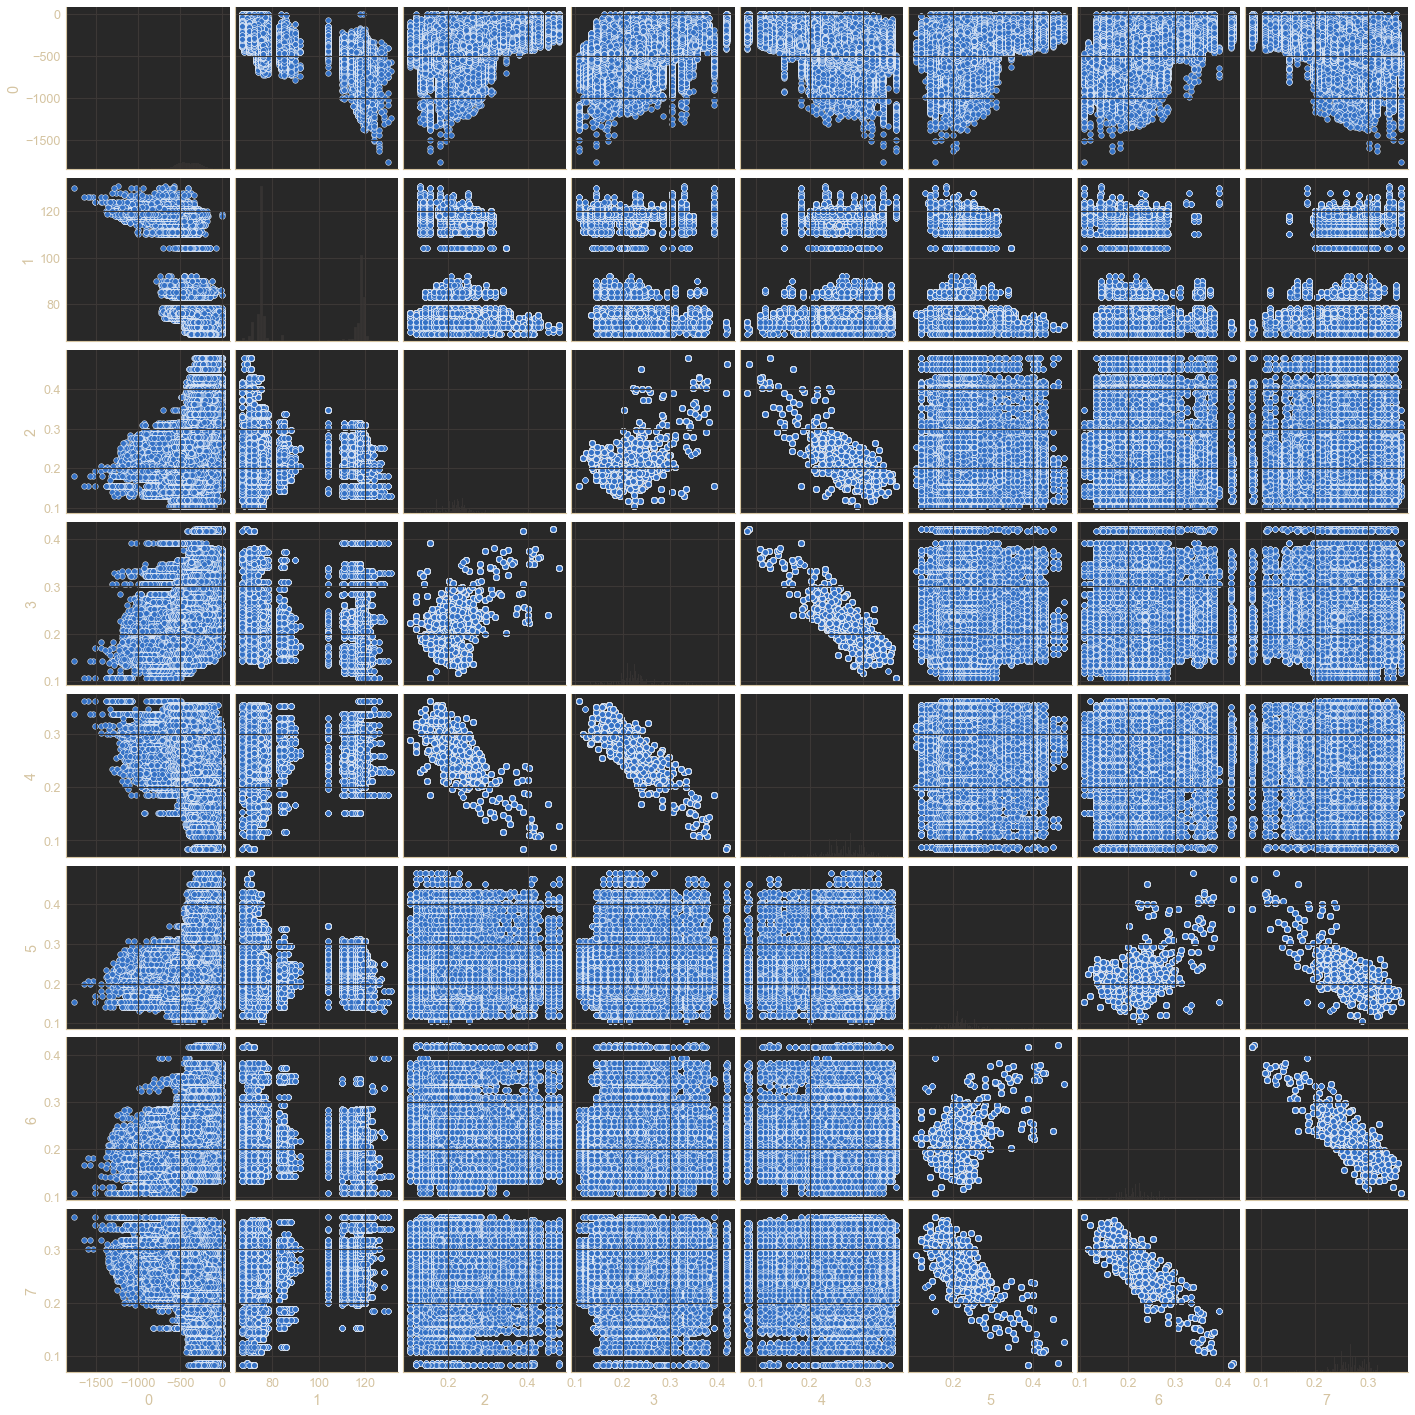

In [14]:
### Correlogram
plt.figure(figsize = (10, 10))
sns.pairplot(X_train, palette = 'bone_r')
plt.show(); plt.close('all')

In [15]:
X_train.skew()

0   -0.569023
1    0.309646
2    1.604151
3    0.963823
4   -1.072249
5    1.654669
6    0.947238
7   -0.993101
dtype: float64

In [16]:
X_train.kurt()

0    0.537908
1   -1.858207
2    4.729130
3    1.961158
4    2.183817
5    4.763173
6    2.366388
7    2.621372
dtype: float64

In [17]:
X_train.corr()

,0,1,2,3,4,5,6,7
0,1.000000,-0.666350,0.206080,0.365353,-0.282798,0.240571,0.324065,-0.286559
1,-0.666350,1.000000,0.053426,-0.226415,0.060654,-0.020784,-0.212406,0.119067
2,0.206080,0.053426,1.000000,0.445777,-0.732834,0.004475,-0.020350,0.010341
3,0.365353,-0.226415,0.445777,1.000000,-0.819611,0.000558,0.039652,-0.021531
4,-0.282798,0.060654,-0.732834,-0.819611,1.000000,-0.004403,-0.005348,0.004315
5,0.240571,-0.020784,0.004475,0.000558,-0.004403,1.000000,0.456395,-0.687943
6,0.324065,-0.212406,-0.020350,0.039652,-0.005348,0.456395,1.000000,-0.865066
7,-0.286559,0.119067,0.010341,-0.021531,0.004315,-0.687943,-0.865066,1.000000


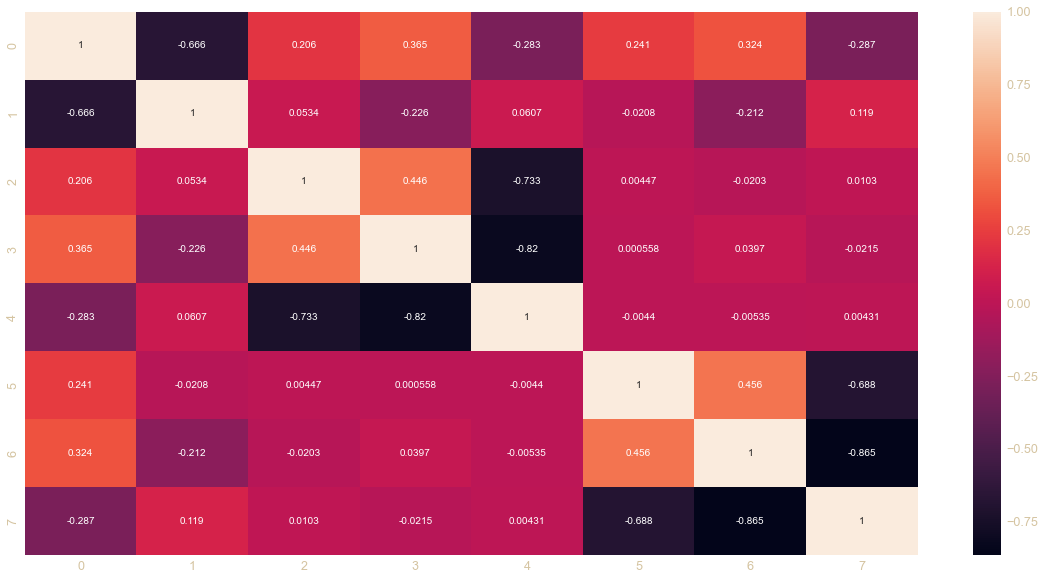

In [18]:
### Correlation heatmap
plt.figure(figsize = (20, 10))
sns.heatmap(X_train.corr(), annot = True, fmt = '.3g')
plt.show()

<b>From the analysis and visualization carried out above, it is obvious that the pairs of features 3 and 4, 5 and 7, 6 and 7, and 2 and 4 possess a strong negative correlation. We will attempt to eliminate this correlation via the PCA technique.<b/>

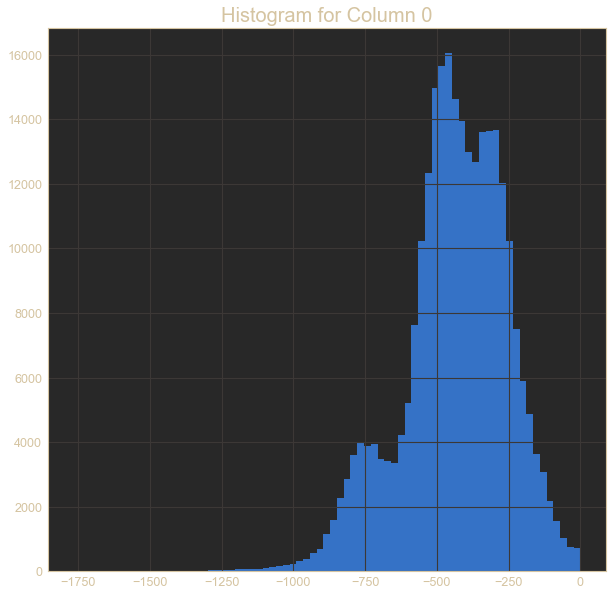

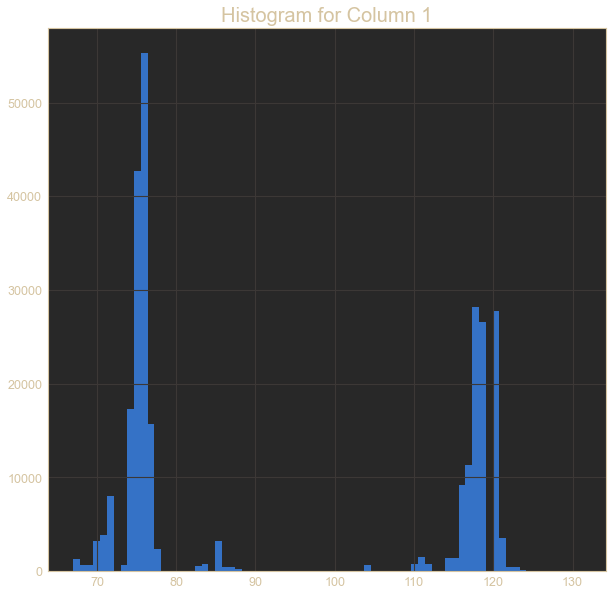

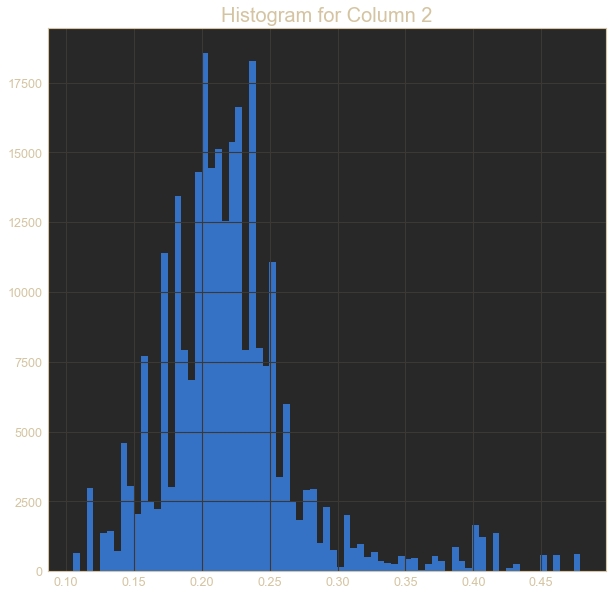

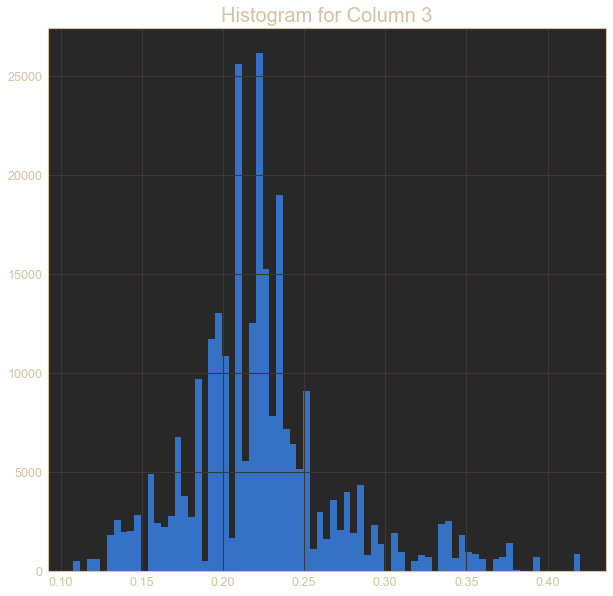

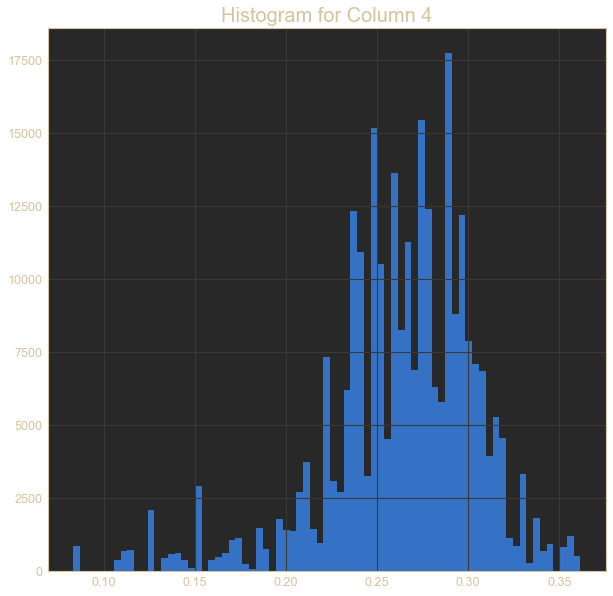

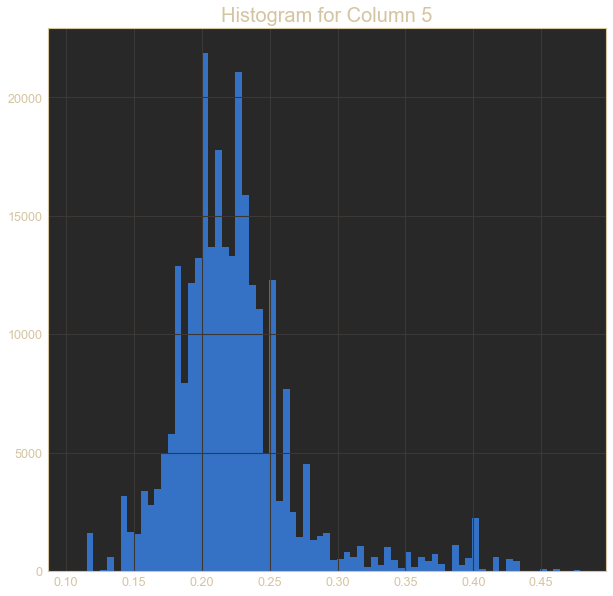

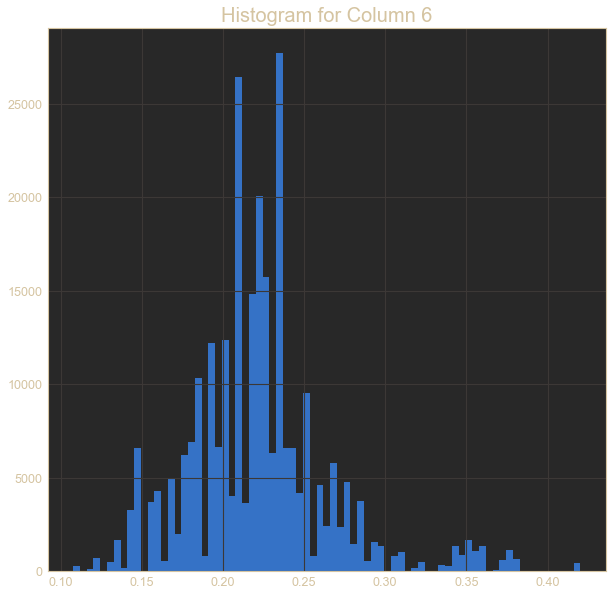

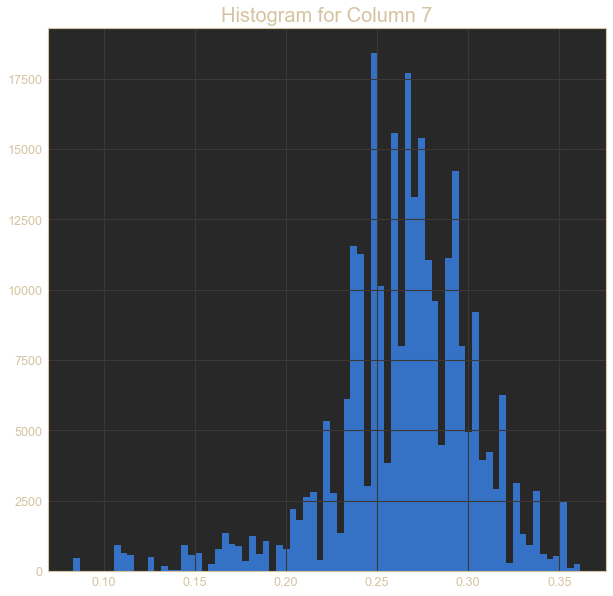

In [19]:
### Univariate analysis
for key in X_train.keys():
    plt.figure(figsize = (10, 10))
    plt.hist(x = X_train[key], bins = 75)
    plt.title(label = f'Histogram for Column {key}', fontsize = 20)
    plt.show(); plt.close('all')

In [20]:
### Feature-to-target correlation
X_train.corrwith(pd.Series(y_train))

0   -5.388327e-01
1    2.924769e-14
2   -8.415856e-16
3    1.041749e-15
4    1.916110e-17
5   -1.121785e-16
6    1.029930e-15
7    5.221923e-16
dtype: float64

In [21]:
X_train.columns

RangeIndex(start=0, stop=8, step=1)

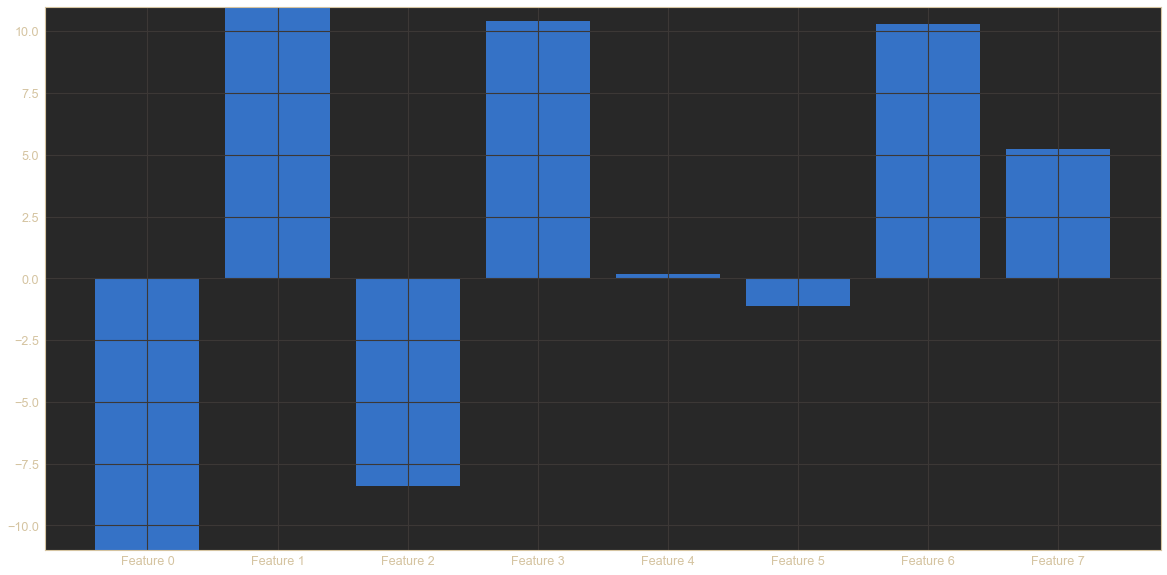

In [22]:
### Visualize feature-target correlation
plt.figure(figsize = (20, 10))

plt.bar(x = X_train.corrwith(pd.Series(y_train)).index,
        height = 1e16 * X_train.corrwith(pd.Series(y_train)))

plt.ylim(top = 11, bottom = -11)
plt.xticks(ticks = X_train.columns, labels = [f'Feature {f}' for f in X_train.columns])

plt.show(); plt.close('all')

<b>From the analysis above, it can be inferred that the first feature has the highest correlation with the target, and may likely be more instrumental in making our predictions. We can also say that the features closely resemble a Gaussian distribution. Another thing to take note of is the fact that a good number of the features exhibit a strong negative correlation with one another.<b/>

In [23]:
### Unique classes
np.unique(y_train)

array([-1.,  1.])

In [24]:
### Reparametrize the target values
y_train = np.where(y_train == -1, 0, y_train)
y_test = np.where(y_test == -1, 0, y_test)

In [25]:
from collections import Counter
print(Counter(y_train))

Counter({0.0: 181078, 1.0: 90539})


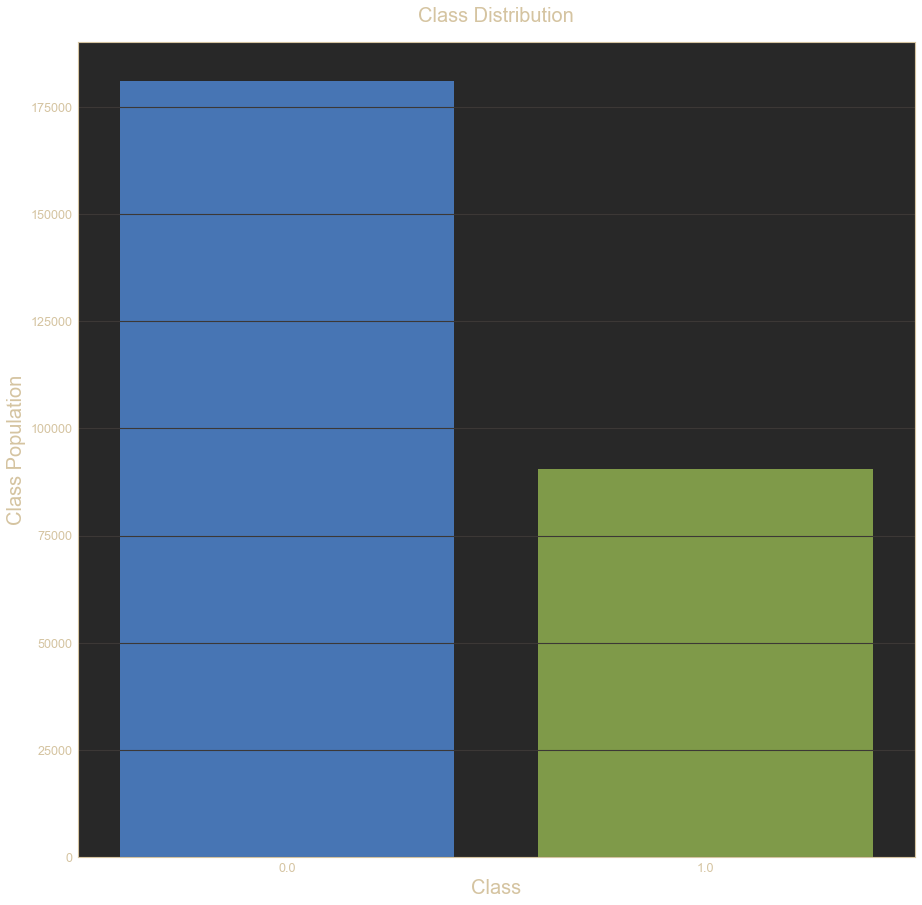

In [26]:
### Class distribution
plt.figure(figsize = (15, 15))
sns.countplot(x = y_train)
plt.title('Class Distribution', pad = 20, fontsize = 20)
plt.xlabel('Class', fontsize = 20)
plt.ylabel('Class Population', fontsize = 20)
plt.show(); plt.close('all')

<b>The data is obviously plagued by a class imbalance of about 2 : 1. This will have to be rectified. We will attempt to rectify this state of affairs using the `SMOTE` object class from the `Imblearn` library.<b/>

In [27]:
from sklearn.metrics import classification_report, roc_auc_score

from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [28]:
gc.collect()

346272

In [29]:
### Instantiate appropriate estimators and transformers
log_reg = LogisticRegression()
svc = SVC(probability = True)


model_dict = {}
i = 0
### Put pipeline together
for model in [log_reg, svc]:
    sampler = SMOTE()
    scaler = MinMaxScaler()
    qtrans = QuantileTransformer(output_distribution = 'normal')
    pca = PCA(n_components = 7, whiten = True)
    
    model_dict[i] = Pipeline(steps = [('scaler', scaler),
                                      ('qtrans', qtrans),
                                      ('PCA', pca),
                                      ('sampler', sampler),
                                      ('model', model)
                                     ]
                            )
    i += 1

In [30]:
n = 0

for model in model_dict.keys():
    model_dict[model].fit(X_train, y_train)
    print(' ')
    print('='*54)
    print('Model-{} performance report'.format(n))
    print('='*54)
    print(' ')
    print('Train Report: ')
    print('='*54)
    print(f'Classification report on train performance for model-{model}',
          f'\n{classification_report(y_train, model_dict[model].predict(X_train))}')
    print(' ')
    
    print('Test Report: ')
    print('='*54)
    print(f'Classification report on test performance for model-{model}',
          f'\n{classification_report(y_test, model_dict[model].predict(X_test))}')
    print(' ')
    
    n += 1

 
Model-0 performance report
 
Train Report: 
Classification report on train performance for model-0 
              precision    recall  f1-score   support

         0.0       0.94      0.89      0.92    181078
         1.0       0.80      0.89      0.84     90539

    accuracy                           0.89    271617
   macro avg       0.87      0.89      0.88    271617
weighted avg       0.90      0.89      0.89    271617

 
Test Report: 
Classification report on test performance for model-0 
              precision    recall  f1-score   support

         0.0       0.95      0.85      0.90     39690
         1.0       0.75      0.91      0.82     19845

    accuracy                           0.87     59535
   macro avg       0.85      0.88      0.86     59535
weighted avg       0.88      0.87      0.87     59535

 
 
Model-1 performance report
 
Train Report: 
Classification report on train performance for model-1 
              precision    recall  f1-score   support

         0.0  

---

<b>ROC-AUC score for Logistic Regression<b/>

In [31]:
### Training performance
roc_auc_score(y_train, model_dict[0].predict(X_train))

0.8913617336175571

In [32]:
### Test performance
roc_auc_score(y_test, model_dict[0].predict(X_test))

0.8802595112118922

---

<b>ROC-AUC score for SVM<b/>

In [33]:
### Training performance
roc_auc_score(y_train, model_dict[1].predict(X_train))

0.9558864135897237

In [34]:
### Test performance
roc_auc_score(y_test, model_dict[1].predict(X_test))

0.9436130007558579

---

<strong>From the above, it can be inferred that <u>Support Vector Machines</u> make a better choice for modelling than the Logistic Regression algorithm. Further investigation may be carried out to seek out improvements.</strong>

In [35]:
### Serialize and export model
joblib.dump(model_dict[1], open('SVC-artefact.bin', 'wb'))

In [36]:
best_thresh = None
best_score = 0
thresh_score_dict = {}

for thresh in np.arange(0.45, 0.5, 0.002):
    preds = model_dict[1].predict_proba(X_test)[:, 1]
    preds = np.where(preds > thresh, 1, 0)
    
    score = roc_auc_score(y_test, preds)
    thresh_score_dict[thresh] = score
    
    if score > best_score:
        best_score = score
        best_thresh = thresh
    
    print(f'Best score {best_score : .4f} is obtained at a threshold of {best_thresh}')
        
print()
print(f'Final best score {best_score : .4f} is obtained at a threshold of {best_thresh}')

Best score  0.9434 is obtained at a threshold of 0.45
Best score  0.9434 is obtained at a threshold of 0.452
Best score  0.9434 is obtained at a threshold of 0.452
Best score  0.9434 is obtained at a threshold of 0.452
Best score  0.9434 is obtained at a threshold of 0.452
Best score  0.9435 is obtained at a threshold of 0.46
Best score  0.9436 is obtained at a threshold of 0.462
Best score  0.9436 is obtained at a threshold of 0.464
Best score  0.9437 is obtained at a threshold of 0.466
Best score  0.9437 is obtained at a threshold of 0.468
Best score  0.9438 is obtained at a threshold of 0.47000000000000003
Best score  0.9438 is obtained at a threshold of 0.47200000000000003
Best score  0.9438 is obtained at a threshold of 0.47200000000000003
Best score  0.9438 is obtained at a threshold of 0.47600000000000003
Best score  0.9439 is obtained at a threshold of 0.47800000000000004
Best score  0.9440 is obtained at a threshold of 0.48000000000000004
Best score  0.9441 is obtained at a th

In [38]:
thresh_score_dict

{0.45: 0.9433736457545981,
 0.452: 0.9433862433862433,
 0.454: 0.9433484504913077,
 0.456: 0.9433484504913077,
 0.458: 0.9433862433862433,
 0.46: 0.9434996220710506,
 0.462: 0.9435878054925673,
 0.464: 0.9436004031242127,
 0.466: 0.9436633912824388,
 0.468: 0.9436759889140842,
 0.47000000000000003: 0.9437515747039557,
 0.47200000000000003: 0.9438271604938272,
 0.47400000000000003: 0.9437893675988913,
 0.47600000000000003: 0.9438397581254724,
 0.47800000000000004: 0.9439027462836987,
 0.48000000000000004: 0.9440035273368607,
 0.48200000000000004: 0.9440665154950869,
 0.48400000000000004: 0.9441798941798942,
 0.48600000000000004: 0.9441672965482489,
 0.48800000000000004: 0.9441924918115395,
 0.49000000000000005: 0.94421768707483,
 0.49200000000000005: 0.9441546989166038,
 0.49400000000000005: 0.9442050894431847,
 0.49600000000000005: 0.9442050894431846,
 0.49800000000000005: 0.9442050894431846}

In [42]:
with open(os.path.join(os.getcwd().replace('notebooks', 'artefacts'), 'thresh_data.json'), 'w') as f:
    json.dump(thresh_score_dict, f)